# PySpark Deep Dive 1
### GRADTDA 5622, Tom Bihari instructor
This notebook contains examples of some of the important concepts in PySpark.

Some good resources:
- https://spark.apache.org/docs/latest/api/python/index.html
- https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/frame.html
- https://sparkbyexamples.com/pyspark-tutorial/
***

***
# Section: Setup
- Add any needed imports, helper functions, etc., here.
***

In [1]:
try:
    import pyspark
except:
    print('Installing pyspark')
    !pip install pyspark
    import pyspark

# try:
#     import pyspark_config
# except:
#     print('Installing pyspark_config')
#     !pip install pyspark_config
#     import pyspark_config

In [2]:
# NOTE: If any of these libraries are not already loaded on OSC Jupyter+Spark (e.g., seaborn),
#  go the the Launcher (New Launcher in the JupyterLab Files menu), open a Terminal, and type
#  "pip install seaborn" (or the needed library).
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from time import time
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as SqlF

pd.set_option('display.max_columns', 50) #include to avoid ... in middle of display
pyspark.__version__

'3.5.4'

In [3]:
spark = SparkSession.builder.master("local[*]") \
                    .appName('MyApp') \
                    .getOrCreate()
sc = spark.sparkContext  # Get the context, so we have a short name for it if we need it.
#print(sc.appName)

In [4]:
# Identify the location of the shared data folder
# shared_data_directory = "../shared_Sp22/"
shared_data_directory = "/content/"

***
# Section: RDDs and DataFrames
***

## Resilient Distributed Datasets
**RDDs** or Resilient Distributed Datasets are specialized data structures used by spark to hide all the complexity of transforming and distributing your data automatically. `RDDs` are immutable elements, which means once you create an RDD you cannot change it. They can only be transformed to create new RDDs. (Think tuple, you can make them but you cant update them without creating them again). RDDs are fault tolerant as well, hence in case of any failure, they recover automatically. You can apply multiple operations on these RDDs to achieve a certain task.

### Creating RDDs

There are several ways to create RDDs in pyspark. We list the most common ways below:


### Using the `paralellize()` function

In [5]:
example1_rdd = sc.parallelize(
    [(1, 2, 3, 'abc'),
     (4, 5, 6, 'def'),
     (7, 8, 9, 'ghi')
    ])
example1_rdd.collect()

[(1, 2, 3, 'abc'), (4, 5, 6, 'def'), (7, 8, 9, 'ghi')]

### Reading from a CSV file, using the textFile function.

In [8]:
iris_rdd = sc.textFile(shared_data_directory + 'iris_dataset.csv')
print(iris_rdd.count())
print(iris_rdd.take(3))

151
['sepal_length,sepal_width,petal_length,petal_width,species', '5.1,3.5,1.4,0.2,setosa', '4.9,3.0,1.4,0.2,setosa']


## Spark DataFrames
A Spark DataFrame object is different from a Pandas DataFrame. It has different APIs and functions quite differently in many ways. To learn the differences between an rdd.DataFrame vs pd.DataFrame, please refer to the following [resource](https://runawayhorse001.github.io/LearningApacheSpark/rdd.html#rdd-dataframe-vs-pd-dataframe).

### Creating DataFrames
There are several ways to create DataFrames in pyspark. We list the most common ways below:

### Using the `createDataFrame()` function

In [9]:
employee_df = spark.createDataFrame(
    [('1', 'Joe',   '70000', '1'),
     ('2', 'Henry', '80000', '2'),
     ('3', 'Sam',   '60000', '2'),
     ('4', 'Max',   '90000', '1')],
     ['Id', 'Name', 'Salary','DepartmentId']
)
employee_df.show()

+---+-----+------+------------+
| Id| Name|Salary|DepartmentId|
+---+-----+------+------------+
|  1|  Joe| 70000|           1|
|  2|Henry| 80000|           2|
|  3|  Sam| 60000|           2|
|  4|  Max| 90000|           1|
+---+-----+------+------------+



### Reading from a CSV file, using the `read()` and `load()` functions.

In [10]:
iris_df = spark.read.format('csv').load(shared_data_directory + "iris_dataset.csv", header=True, inferSchema=True)
iris_df.show(5)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows



## Converting between RDDs and DataFrames

In [11]:
# Convert RDD to DataFrame (using the example1_rdd from above)
example1_df = example1_rdd.toDF()
example1_df.show()

+---+---+---+---+
| _1| _2| _3| _4|
+---+---+---+---+
|  1|  2|  3|abc|
|  4|  5|  6|def|
|  7|  8|  9|ghi|
+---+---+---+---+



In [12]:
# Convert DataFrame to RDD
example1b_rdd = example1_df.rdd.map(tuple)
example1b_rdd.collect()

[(1, 2, 3, 'abc'), (4, 5, 6, 'def'), (7, 8, 9, 'ghi')]

# Section: Key Concepts for Spark and DataFrames
- For the remainder of this tutorial, we will use **Spark** DataFrames (not RDDs).

## Concept: DataFrames are Immutable.  They are not modifiable after they are created.
- Spark uses a **functional** paradigm.  Spark operations executed on a DataFrame return a **new DataFrame** with the changes.

In [13]:
# DataFrame from above
employee_df.show()

+---+-----+------+------------+
| Id| Name|Salary|DepartmentId|
+---+-----+------+------------+
|  1|  Joe| 70000|           1|
|  2|Henry| 80000|           2|
|  3|  Sam| 60000|           2|
|  4|  Max| 90000|           1|
+---+-----+------+------------+



In [14]:
# Drop a column.  It still is there!
employee_df.drop("Salary")
employee_df.show()

+---+-----+------+------------+
| Id| Name|Salary|DepartmentId|
+---+-----+------+------------+
|  1|  Joe| 70000|           1|
|  2|Henry| 80000|           2|
|  3|  Sam| 60000|           2|
|  4|  Max| 90000|           1|
+---+-----+------+------------+



In [15]:
# Drop a column and assign the return value to a variable.
#  The column is now gone in the new DataFrame (but still is in the original one).
new_employee_df = employee_df.drop("Salary")
new_employee_df.show()
employee_df.show()

+---+-----+------------+
| Id| Name|DepartmentId|
+---+-----+------------+
|  1|  Joe|           1|
|  2|Henry|           2|
|  3|  Sam|           2|
|  4|  Max|           1|
+---+-----+------------+

+---+-----+------+------------+
| Id| Name|Salary|DepartmentId|
+---+-----+------+------------+
|  1|  Joe| 70000|           1|
|  2|Henry| 80000|           2|
|  3|  Sam| 60000|           2|
|  4|  Max| 90000|           1|
+---+-----+------+------------+



In [16]:
# Add a column and assign the return value to the same variable.
#  The column is in the newer DataFrame, and the variable now points to the newer DataFrame.
#  The connection to the previous "new" one is lost, and if no other code references that
#  DataFrame, it will be Garbage Collected.
new_employee_df = new_employee_df.withColumn("Age", SqlF.lit(29))
new_employee_df.show()

+---+-----+------------+---+
| Id| Name|DepartmentId|Age|
+---+-----+------------+---+
|  1|  Joe|           1| 29|
|  2|Henry|           2| 29|
|  3|  Sam|           2| 29|
|  4|  Max|           1| 29|
+---+-----+------------+---+



## Concept: Spark provides two types of operations: Transformations and Actions.
- **Transformations** "transform" DataFrames in typical ways: selecting rows, sorting, aggregating data, etc.
- **Actions** trigger the preceding transformations to execute.  Nothing happens until an Action is called.
- This **Lazy Evaluation** allows Spark to optimize the code, performing the transformations in whatever way is most effective and efficient.  Think of transformations as specifying **what** you want to have done, not **how** to do it.

In [17]:
# Specify a couple of transformations (drop, withColumn).
new_employee_df = employee_df.drop("Salary")
new_employee_df = new_employee_df.withColumn("Age", SqlF.lit(29))
# NOTHING happens yet

In [18]:
# Specify an action (show the DataFrame).
new_employee_df.show()
# NOW the transformations happen!

+---+-----+------------+---+
| Id| Name|DepartmentId|Age|
+---+-----+------------+---+
|  1|  Joe|           1| 29|
|  2|Henry|           2| 29|
|  3|  Sam|           2| 29|
|  4|  Max|           1| 29|
+---+-----+------------+---+



In [19]:
# You can "chain" these operations together in a single statement.
new_employee_df = employee_df.drop("Salary").withColumn("Age", SqlF.lit(29)).show()

+---+-----+------------+---+
| Id| Name|DepartmentId|Age|
+---+-----+------------+---+
|  1|  Joe|           1| 29|
|  2|Henry|           2| 29|
|  3|  Sam|           2| 29|
|  4|  Max|           1| 29|
+---+-----+------------+---+



In [20]:
# Or like this, for better readability. Note the outer parentheses.
new_employee_df = (employee_df
    .drop("Salary")
    .withColumn("Age", SqlF.lit(29))
    .show())

+---+-----+------------+---+
| Id| Name|DepartmentId|Age|
+---+-----+------------+---+
|  1|  Joe|           1| 29|
|  2|Henry|           2| 29|
|  3|  Sam|           2| 29|
|  4|  Max|           1| 29|
+---+-----+------------+---+



In [21]:
# Or like this, for better readability. Note backslash line-continuation characters.
new_employee_df = employee_df         \
    .drop("Salary")                   \
    .withColumn("Age", SqlF.lit(29))  \
    .show()

+---+-----+------------+---+
| Id| Name|DepartmentId|Age|
+---+-----+------------+---+
|  1|  Joe|           1| 29|
|  2|Henry|           2| 29|
|  3|  Sam|           2| 29|
|  4|  Max|           1| 29|
+---+-----+------------+---+



# Section: Common Transformations and Actions
- Here are some common transformations and actions on DataFrames.
- For a reference of all transformations and actions, see here:
  - https://spark.apache.org/docs/latest/api/python/index.html
  - https://sparkbyexamples.com/pyspark-tutorial/

In [22]:
print(iris_df.count())
iris_df.printSchema()
iris_df.show(2,truncate=False)

150
root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|5.1         |3.5        |1.4         |0.2        |setosa |
|4.9         |3.0        |1.4         |0.2        |setosa |
+------------+-----------+------------+-----------+-------+
only showing top 2 rows



In [23]:
iris_df.describe().show()

+-------+------------------+-------------------+------------------+------------------+---------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|  species|
+-------+------------------+-------------------+------------------+------------------+---------+
|  count|               150|                150|               150|               150|      150|
|   mean| 5.843333333333335| 3.0540000000000007|3.7586666666666693|1.1986666666666672|     NULL|
| stddev|0.8280661279778637|0.43359431136217375| 1.764420419952262|0.7631607417008414|     NULL|
|    min|               4.3|                2.0|               1.0|               0.1|   setosa|
|    max|               7.9|                4.4|               6.9|               2.5|virginica|
+-------+------------------+-------------------+------------------+------------------+---------+



In [24]:
# Create a new DataFrame that contains only a subset of the columns (not the sepal_length and sepal_width).
temp_df = iris_df.select('petal_length','petal_width','species').show(2)

+------------+-----------+-------+
|petal_length|petal_width|species|
+------------+-----------+-------+
|         1.4|        0.2| setosa|
|         1.4|        0.2| setosa|
+------------+-----------+-------+
only showing top 2 rows



In [25]:
# Create a new DataFrame that contains only records for the versicolor species.
temp_df = iris_df.filter(iris_df.species == "versicolor").show(2)
# The "where" function is the same as "filter".
temp_df = iris_df.where(iris_df.species == "versicolor").show(2)

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|   species|
+------------+-----------+------------+-----------+----------+
|         7.0|        3.2|         4.7|        1.4|versicolor|
|         6.4|        3.2|         4.5|        1.5|versicolor|
+------------+-----------+------------+-----------+----------+
only showing top 2 rows

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|   species|
+------------+-----------+------------+-----------+----------+
|         7.0|        3.2|         4.7|        1.4|versicolor|
|         6.4|        3.2|         4.5|        1.5|versicolor|
+------------+-----------+------------+-----------+----------+
only showing top 2 rows



In [26]:
# Group by species and compute the aggregated minimum.
temp_df = (iris_df
    .groupBy("species")
    .agg(SqlF.min("sepal_length").alias("min_sl"))
    .orderBy("species",ascending=True))

temp_df.show()

+----------+------+
|   species|min_sl|
+----------+------+
|    setosa|   4.3|
|versicolor|   4.9|
| virginica|   4.9|
+----------+------+



In [27]:
# Group by species and compute three aggregated values.
# If performng multiple aggregations, you have to use the "agg" operation.
temp_df = (iris_df
    .groupBy("species")
    .agg(SqlF.min("sepal_length").alias("min_sl"),
         SqlF.avg("sepal_length").alias("avg_sl"),
         SqlF.max("sepal_length").alias("max_sl"))
    .orderBy("species",ascending=True))

temp_df.show()

+----------+------+-----------------+------+
|   species|min_sl|           avg_sl|max_sl|
+----------+------+-----------------+------+
|    setosa|   4.3|5.005999999999999|   5.8|
|versicolor|   4.9|            5.936|   7.0|
| virginica|   4.9|6.587999999999998|   7.9|
+----------+------+-----------------+------+



In [28]:
# Rename a column.
temp_df = iris_df.withColumnRenamed("sepal_length", "length_of_sepal").show(2)

+---------------+-----------+------------+-----------+-------+
|length_of_sepal|sepal_width|petal_length|petal_width|species|
+---------------+-----------+------------+-----------+-------+
|            5.1|        3.5|         1.4|        0.2| setosa|
|            4.9|        3.0|         1.4|        0.2| setosa|
+---------------+-----------+------------+-----------+-------+
only showing top 2 rows



In [29]:
# Create two temporary DataFrames to join.
temp1_df = employee_df.drop("Salary")
temp1_df.show()
temp2_df = employee_df.drop("DepartmentId")
temp2_df.show()

# Join (left-outer) the two DataFrames.
temp3_df = temp1_df.join(temp2_df, on=['Id'],how='left')
temp3_df.show()

+---+-----+------------+
| Id| Name|DepartmentId|
+---+-----+------------+
|  1|  Joe|           1|
|  2|Henry|           2|
|  3|  Sam|           2|
|  4|  Max|           1|
+---+-----+------------+

+---+-----+------+
| Id| Name|Salary|
+---+-----+------+
|  1|  Joe| 70000|
|  2|Henry| 80000|
|  3|  Sam| 60000|
|  4|  Max| 90000|
+---+-----+------+

+---+-----+------------+-----+------+
| Id| Name|DepartmentId| Name|Salary|
+---+-----+------------+-----+------+
|  1|  Joe|           1|  Joe| 70000|
|  2|Henry|           2|Henry| 80000|
|  3|  Sam|           2|  Sam| 60000|
|  4|  Max|           1|  Max| 90000|
+---+-----+------------+-----+------+



In [30]:
# Get the DepartmentId for Sam.
sam_dept_id = employee_df.filter(employee_df.Name == "Sam").collect()[0]['DepartmentId']
print(sam_dept_id)

2


# Section: Using Pyspark with SQL
- DataFrames can be manipulated with Spark functions (as above) or with SQL.
- The choice is mostly personal preference.

In [ ]:
# Register a SQL-compliant table for the iris DataFrame.
iris_df.registerTempTable("iris_table")

In [32]:
# Same query as we did above using Spark functions. Do it now using SQL.
result = spark.sql("""
    SELECT species, min(sepal_length) AS min_sl, avg(sepal_length) AS avg_sl, max(sepal_length) AS max_sl
        FROM iris_table
        GROUP BY species
        ORDER BY species ASC
                """)
result.show()

+----------+------+-----------------+------+
|   species|min_sl|           avg_sl|max_sl|
+----------+------+-----------------+------+
|    setosa|   4.3|5.005999999999999|   5.8|
|versicolor|   4.9|            5.936|   7.0|
| virginica|   4.9|6.587999999999998|   7.9|
+----------+------+-----------------+------+



***
# Section: PySpark DataFrames and Pandas DataFrames
- Compare Spark and Pandas operations, using the **iris Spark DataFrame** created above.
- In general:
  - Use Spark for manipulating large datasets.  Pandas typically runs slowly or "breaks" on large datasets.  See: https://databricks.com/blog/2018/05/03/benchmarking-apache-spark-on-a-single-node-machine.html
  - Use Pandas for smaller, summarized or sampled datasets.  Pandas and related libraries offer a huge variety of algorithms, visualizations, and support functions.  Spark is growing in that way, but is not nearly as comprehensive as Pandas.
  - Example workflow: Do the "big-data" crunching using Spark and create summarized datasets. Use Pandas to process those summarized datasets.
  - There are more sophisticated ways to use Spark + Pandas.  See **Pandas UDFs** in Spark: https://databricks.com/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html
***

In [33]:
# Create a Pandas DataFrame from the Spark DataFrame
iris_pdf = iris_df.toPandas()
iris_pdf.head(2)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa


In [34]:
# Create a new Spark DataFrame from the Pandas DataFrame
new_spark_df = spark.createDataFrame(iris_pdf)
new_spark_df.show(2)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 2 rows



In [35]:
# Example of when to use Pandas
# This runs the describe function on a potentially large Spark DataFrame, and generates a short summary Spark DataFrame.
# The it converts this summary DataFrame to a Pandas DataFrame, so it prints nicely.
iris_df.describe().toPandas()

,summary,sepal_length,sepal_width,petal_length,petal_width,species
0,count,150,150,150,150,150
1,mean,5.843333333333335,3.0540000000000007,3.7586666666666693,1.1986666666666672,None
2,stddev,0.8280661279778637,0.43359431136217375,1.764420419952262,0.7631607417008414,None
3,min,4.3,2.0,1.0,0.1,setosa
4,max,7.9,4.4,6.9,2.5,virginica


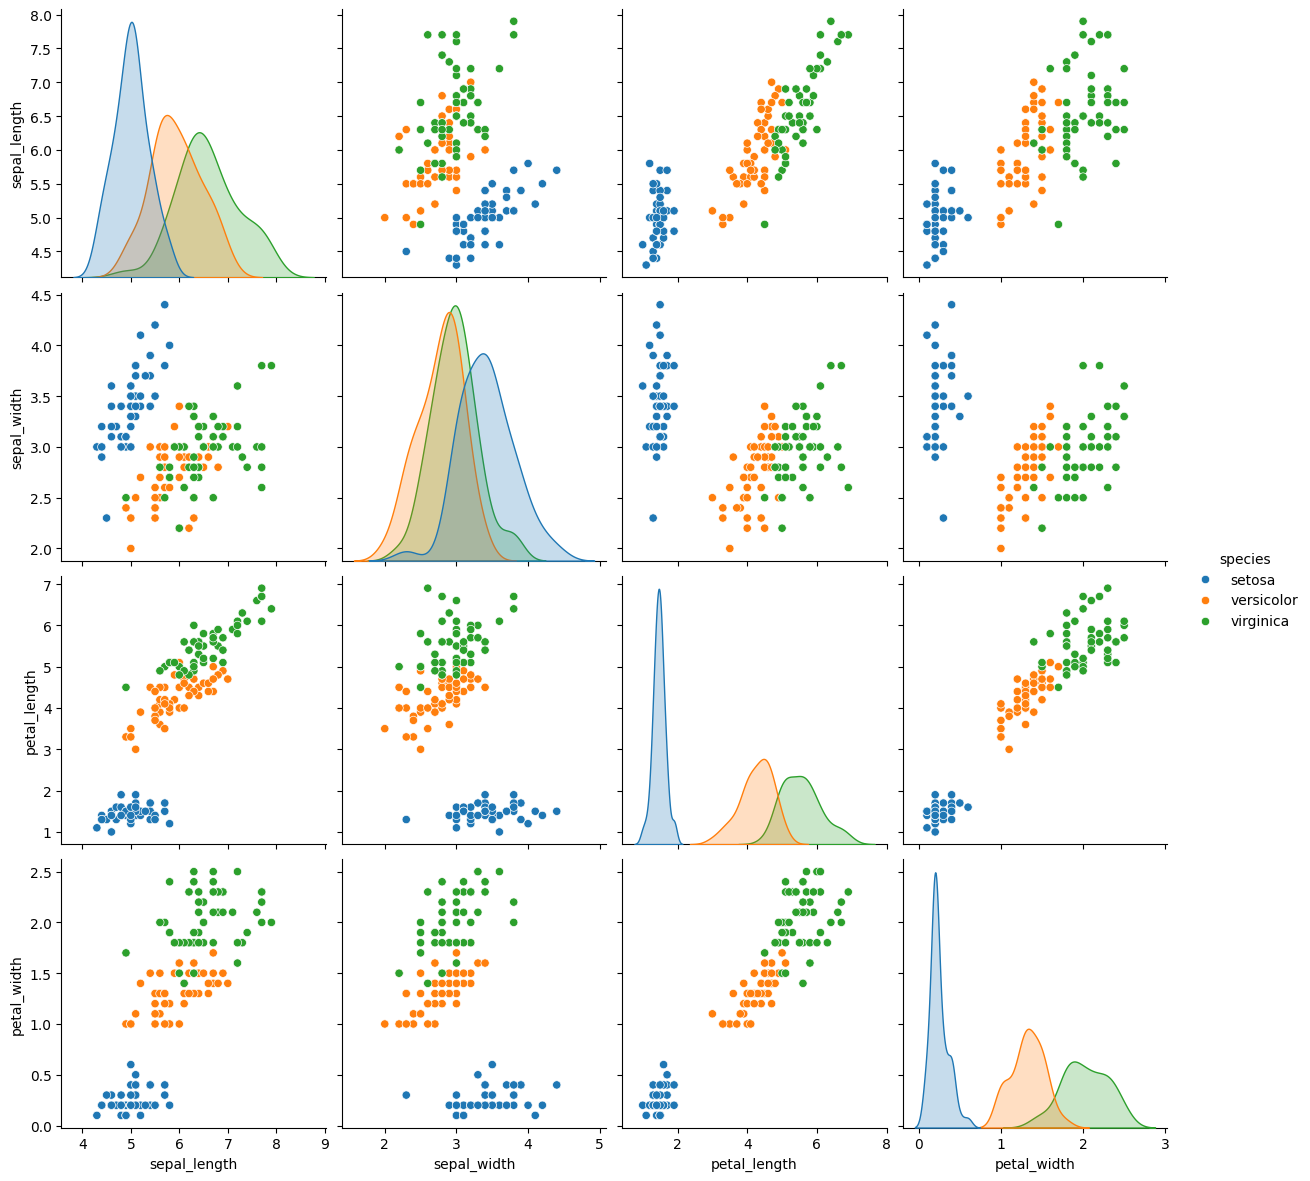

In [36]:
# Lots of support for visualizing Pandas DataFrames.
import seaborn as sns
sns.pairplot(data = iris_pdf[['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']], hue="species", height=3)
plt.show()

***
# Conclusion
- We touched just the tip of the iceberg regarding Spark and PySpark. For additional examples and deeper reading, see the references listed at the top of this notebook, and the many resources on the web.
***